# Step 1: Data Cleaning

In [23]:
# installing needed libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import optuna
from tqdm import tqdm
import pickle
from scipy.special import inv_boxcox
from pathlib import Path

In [41]:
# Define the path to the data directory relative to the notebook's location
data_dir = Path.cwd().parent / 'data'

# Load the dataset (assuming it’s saved as 'data - Raw Data.csv')
df = pd.read_csv(data_dir / 'diamonds.csv')

# Clean 'Carat Weight' by removing extra spaces and converting to float
df['Carat Weight'] = df['Carat Weight'].str.replace('"', '').str.replace(',', '.').str.strip().astype(float)

# Clean 'Price' by removing '$' and spaces, then converting to float
df['Price'] = df['Price'].str.replace('[\$,]', '', regex=True).str.replace('\xa0', '').astype(float)

# Drop the 'ID' column as it’s not relevant for prediction
df = df.drop('ID', axis=1)

# Verify no missing values
print(df.isnull().sum())  # Should all be 0; if not, we’d handle them

Carat Weight    0
Cut             0
Color           0
Clarity         0
Polish          0
Symmetry        0
Report          0
Price           0
dtype: int64


<>:11: SyntaxWarning: invalid escape sequence '\$'
<>:11: SyntaxWarning: invalid escape sequence '\$'
C:\Users\Admin\AppData\Local\Temp\ipykernel_12488\3551474337.py:11: SyntaxWarning: invalid escape sequence '\$'
  df['Price'] = df['Price'].str.replace('[\$,]', '', regex=True).str.replace('\xa0', '').astype(float)


In [25]:
df.sample(5)  # Display a random sample of 5 rows to verify the changes

,Carat Weight,Cut,Color,Clarity,Polish,Symmetry,Report,Price
5288,0.90,Good,E,SI1,G,VG,GIA,4283.0
2012,1.05,Ideal,H,SI1,VG,VG,GIA,5095.0
1671,2.48,Very Good,F,VVS1,VG,VG,GIA,50585.0
3629,2.04,Very Good,F,VS1,EX,EX,GIA,33081.0
14,1.50,Very Good,F,SI1,VG,VG,GIA,11004.0


# Step 2: Feature Engineering

In [26]:
# Define mappings
cut_mapping = {'Fair': 1, 'Good': 2, 'Very Good': 3, 'Ideal': 4, 'Signature-Ideal': 5}
color_mapping = {'J': 1, 'I': 2, 'H': 3, 'G': 4, 'F': 5, 'E': 6, 'D': 7}
clarity_mapping = {'I1': 1, 'SI2': 2, 'SI1': 3, 'VS2': 4, 'VS1': 5, 'VVS2': 6, 'VVS1': 7, 'IF': 8, 'FL': 9}
polish_symmetry_mapping = {'G': 3, 'VG': 4, 'EX': 5, 'ID': 5}

# Apply mappings
df['Cut'] = df['Cut'].map(cut_mapping)
df['Color'] = df['Color'].map(color_mapping)
df['Clarity'] = df['Clarity'].map(clarity_mapping)
df['Polish'] = df['Polish'].map(polish_symmetry_mapping)
df['Symmetry'] = df['Symmetry'].map(polish_symmetry_mapping)

# One-hot encode 'Report'
df = pd.get_dummies(df, columns=['Report'], prefix='Report')
df.drop('Report_GIA', axis=1, inplace=True)  # Drop one of the dummies to avoid multicollinearity

In [27]:
df_check = df.copy()  # Create a copy for checking the changes

In [28]:
# Check for duplicates based on all columns except 'Price'
features_to_check = [col for col in df.columns if col != 'Price']
duplicates = df.duplicated(subset=features_to_check, keep=False)
num_duplicates = duplicates.sum()

print(f"Number of duplicate rows (based on features): {num_duplicates}")
if num_duplicates > 0:
    print("Removing duplicates...")
    df = df.drop_duplicates(subset=features_to_check, keep='first')
    print(f"Dataset size after removing duplicates: {len(df)}")

Number of duplicate rows (based on features): 1793
Removing duplicates...
Dataset size after removing duplicates: 4939


# Summary statistics

In [29]:
# Numerical features summary
print("\nSummary Statistics for Numerical Features:")
print(df[['Carat Weight', 'Price']].describe())

# Categorical features frequency
print("\nCategorical Features Value Counts:")
for col in ['Cut', 'Color', 'Clarity', 'Polish', 'Symmetry', 'Report_AGSL']:
    print(df[col].value_counts())


Summary Statistics for Numerical Features:
       Carat Weight          Price
count   4939.000000    4939.000000
mean       1.355598   12246.331646
std        0.484215   10553.595703
min        0.750000    2184.000000
25%        1.010000    5292.000000
50%        1.180000    8359.000000
75%        1.630000   15949.500000
max        2.910000  101561.000000

Categorical Features Value Counts:
Cut
4    2066
3    1954
2     569
5     233
1     117
Name: count, dtype: int64
Color
4    1197
3     904
2     823
5     818
6     645
7     552
Name: count, dtype: int64
Clarity
3    1576
4    1279
5    1002
6     597
7     271
8     210
9       4
Name: count, dtype: int64
Polish
5    2490
4    1922
3     527
Name: count, dtype: int64
Symmetry
5    2228
4    1909
3     802
Name: count, dtype: int64
Report_AGSL
False    4267
True      672
Name: count, dtype: int64


# EDA

## Visualize Distributions

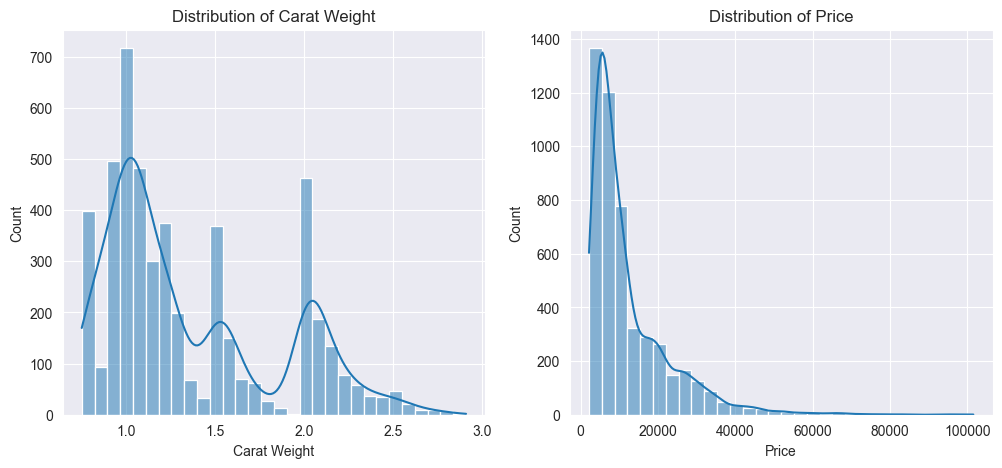

In [30]:
# Numerical Features
plt.figure(figsize=(12, 5))

# Carat Weight
plt.subplot(1, 2, 1)
sns.histplot(df['Carat Weight'], bins=30, kde=True)
plt.title('Distribution of Carat Weight')

# Price
plt.subplot(1, 2, 2)
sns.histplot(df['Price'], bins=30, kde=True)
plt.title('Distribution of Price')
plt.show()

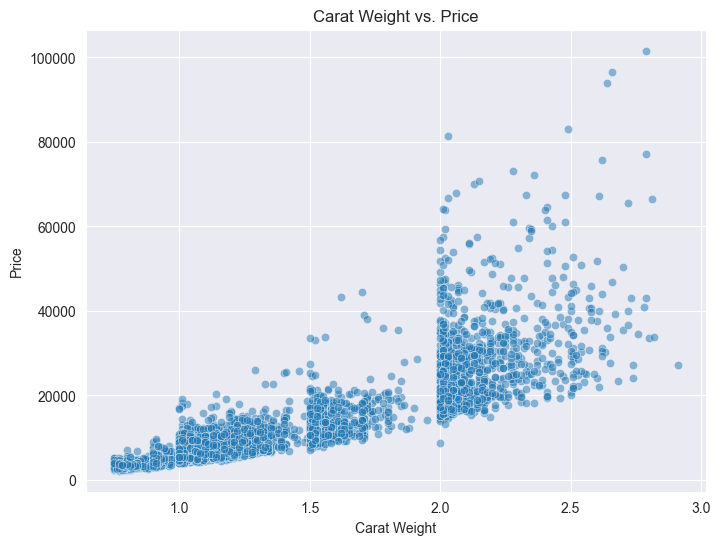

In [31]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='Carat Weight', y='Price', alpha=0.5)
plt.title('Carat Weight vs. Price')
plt.show()

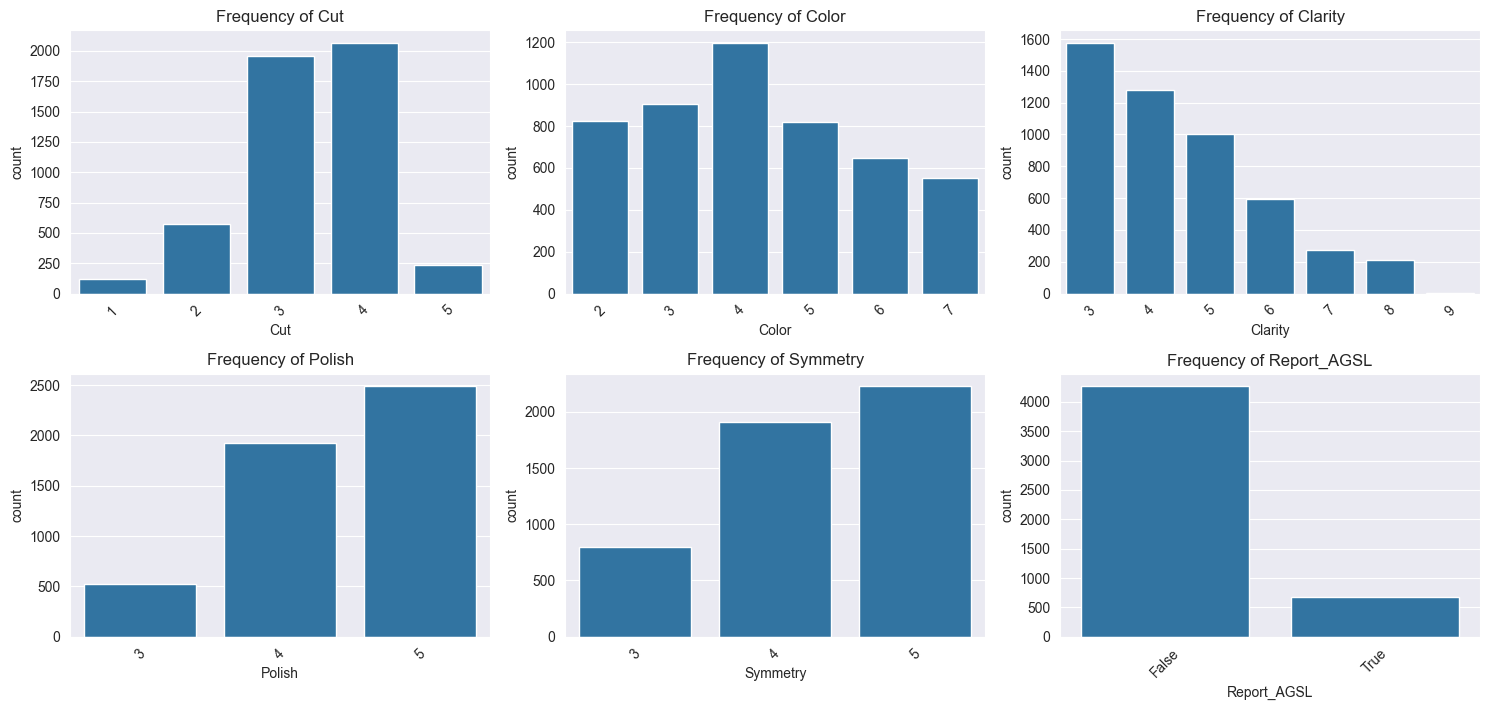

In [32]:
# Categorical Features
categorical_cols = ['Cut', 'Color', 'Clarity', 'Polish', 'Symmetry', 'Report_AGSL']
plt.figure(figsize=(15, 10))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(3, 3, i)
    sns.countplot(data=df, x=col)
    plt.title(f'Frequency of {col}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

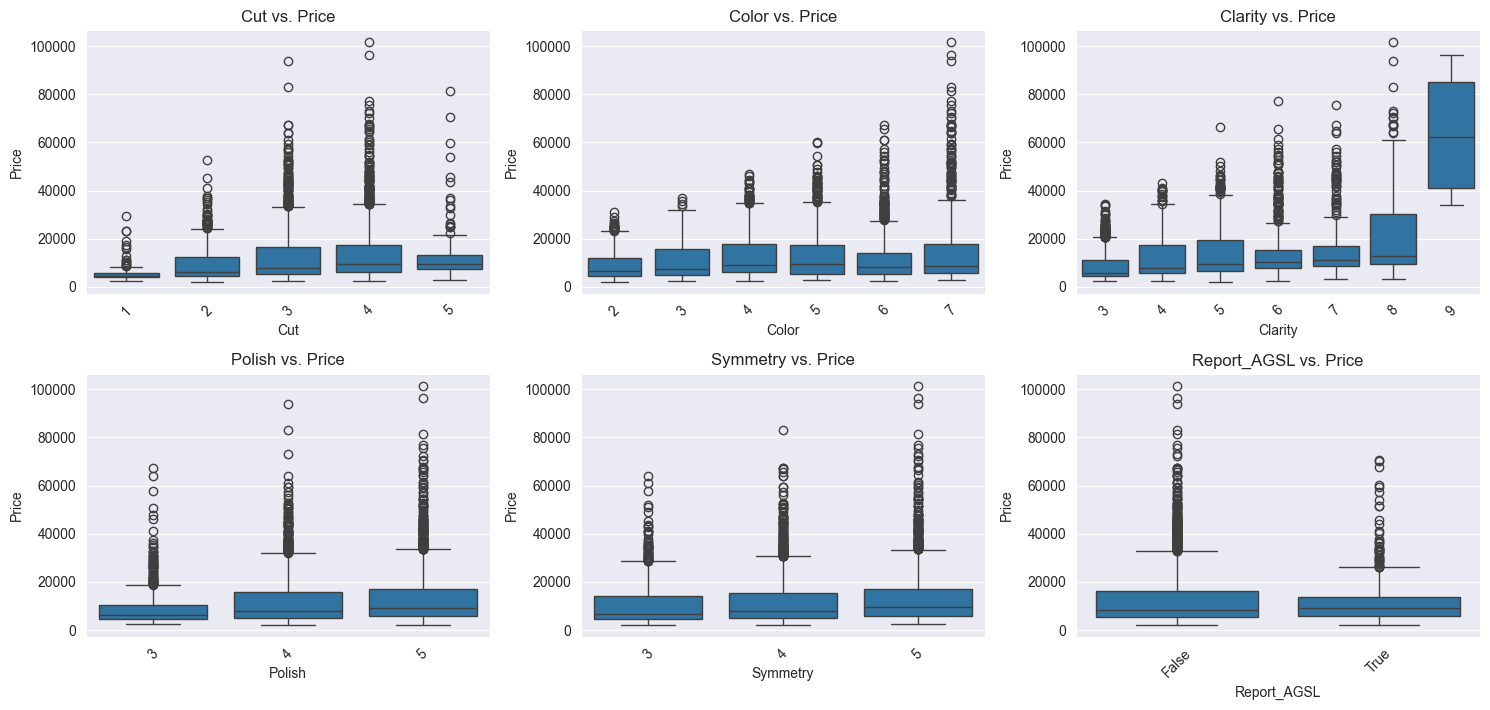

In [33]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(data=df, x=col, y='Price')
    plt.title(f'{col} vs. Price')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

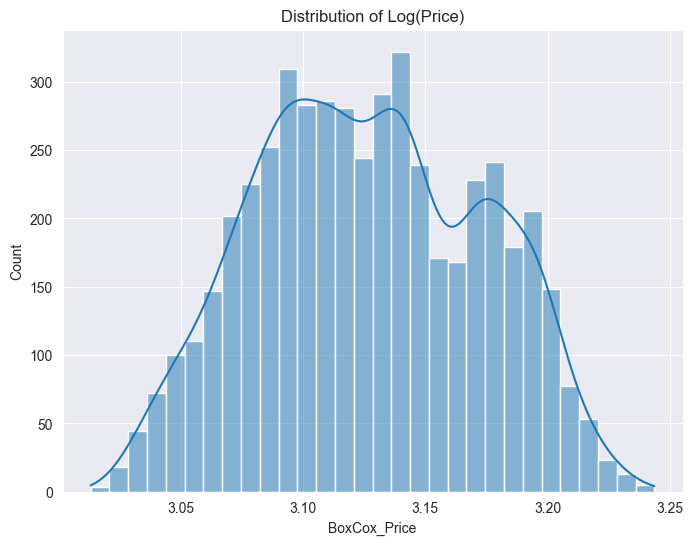

In [34]:
# Apply Box-Cox transformation
df['BoxCox_Price'], lambda_param = boxcox(df['Price'])
plt.figure(figsize=(8, 6))
sns.histplot(df['BoxCox_Price'], bins=30, kde=True)
plt.title('Distribution of Log(Price)')
plt.show()

# Model Training

[I 2025-05-07 20:07:38,828] A new study created in memory with name: no-name-06c2b751-6f78-4276-908b-41afc6f02981
Optuna Trials: 100%|██████████| 200/200 [03:38<00:00,  1.09s/it]


Best Optuna trial value (cross-validation RMSE, Box-Cox): 1180.5072490246853

Feature Importance (Gain-based) after Hyperparameter Tuning (Box-Cox):
        Feature  Importance
0  Carat Weight  107.961204
3       Clarity    9.713582
2         Color    6.609628
1           Cut    1.526247
4        Polish    0.539825
5      Symmetry    0.504723
6   Report_AGSL    0.111173


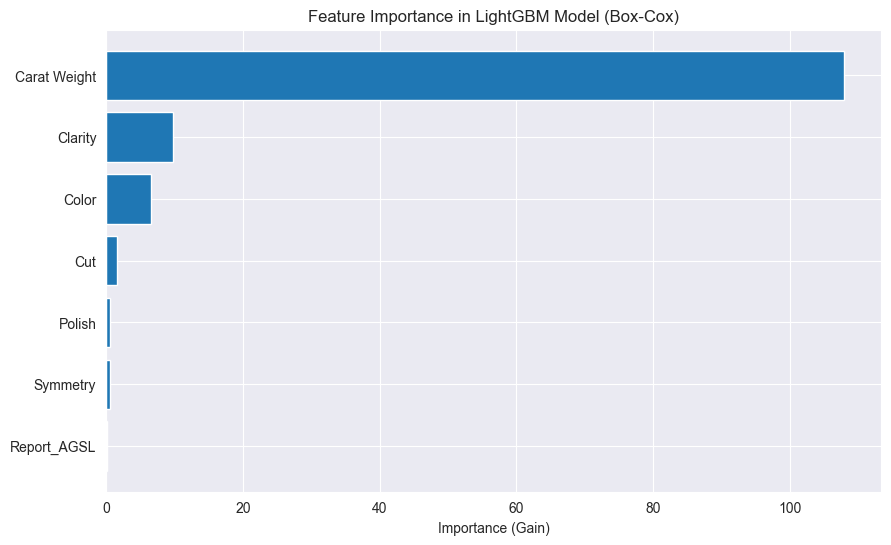

Test RMSE (Box-Cox): 1361.65
Test MAE (Box-Cox): 685.52
Test R² (Box-Cox): 0.9833


In [35]:
# # Feature Engineering
# df['Carat_Clarity'] = df['Carat Weight'] * df['Clarity']
# df['Carat_Color'] = df['Carat Weight'] * df['Color']
# df['Clarity_Color'] = df['Clarity'] * df['Color']
# df['Carat_Cut'] = df['Carat Weight'] * df['Cut']
# df['Polish_Symmetry'] = df['Polish'] * df['Symmetry']
# df['Carat_Weight_Squared'] = df['Carat Weight'] ** 2
# df['Clarity_Squared'] = df['Clarity'] ** 2
# df['Clarity_per_Carat'] = df['Clarity'] / df['Carat Weight'].replace(0, np.nan)
# df['Color_per_Carat'] = df['Color'] / df['Carat Weight'].replace(0, np.nan)
# df['Clarity_Cut'] = df['Clarity'] * df['Cut']
# df['Color_Cut'] = df['Color'] * df['Cut']
# df['Log_Carat_Weight'] = np.log1p(df['Carat Weight'])
# df['Quality_Score'] = df['Clarity'] + df['Color'] + df['Cut']

# Handle any NaN values from division
df = df.fillna(0)

# Define features and target
X = df.drop(columns=['Price', 'BoxCox_Price'])
y = df['BoxCox_Price']  # Use the Box-Cox transformed target

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the Optuna objective with K-Fold Cross-Validation
def objective(trial):
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 20, 200),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 0.9),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 0.9),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 5),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 50),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-6, 1.0),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-6, 1.0),
        'verbosity': -1,
        'num_threads': 6  # Set to the number of physical cores (adjust based on your CPU)
    }

    k_folds = 5
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    rmse_scores = []

    for train_idx, val_idx in kf.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        train_data = lgb.Dataset(X_tr, label=y_tr)
        val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

        model = lgb.train(
            params, train_data,
            num_boost_round=1000,
            valid_sets=[val_data],
            callbacks=[lgb.early_stopping(100, verbose=False)]
        )

        # Back-transform predictions to original scale for RMSE calculation
        preds_boxcox = model.predict(X_val, num_iteration=model.best_iteration)
        preds = inv_boxcox(preds_boxcox, lambda_param)
        y_val_original = inv_boxcox(y_val, lambda_param)
        rmse = np.sqrt(mean_squared_error(y_val_original, preds))
        rmse_scores.append(rmse)

    return np.mean(rmse_scores)

# Run Optuna study with tqdm progress bar
study = optuna.create_study(direction='minimize')
n_trials = 200
with tqdm(total=n_trials, desc="Optuna Trials") as pbar:
    def callback(study, trial):
        pbar.update(1)
    study.optimize(objective, n_trials=n_trials, callbacks=[callback])

print(f"Best Optuna trial value (cross-validation RMSE, Box-Cox): {study.best_value}")

# Train final model with best parameters
best_params = study.best_params
best_params.update({
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'verbosity': -1,
    'num_threads': 6  # Set to the number of physical cores (adjust based on your CPU)
})

train_data = lgb.Dataset(X_train, label=y_train)
final_model = lgb.train(best_params, train_data, num_boost_round=1000)

# Extract feature importance (gain-based)
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': final_model.feature_importance(importance_type='gain')
})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

print("\nFeature Importance (Gain-based) after Hyperparameter Tuning (Box-Cox):")
print(feature_importance)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance (Gain)')
plt.title('Feature Importance in LightGBM Model (Box-Cox)')
plt.gca().invert_yaxis()
plt.show()

# # Save the model to a pickle file
# with open('diamond_price_model_boxcox.pkl', 'wb') as f:
#     pickle.dump(final_model, f)
#
# print("Model saved to 'diamond_price_model_boxcox.pkl'")
#
# # Save the lambda parameter for back-transformation in the Flask app
# with open('boxcox_lambda.pkl', 'wb') as f:
#     pickle.dump(lambda_param, f)
#
# print("Box-Cox lambda parameter saved to 'boxcox_lambda.pkl'")

# Evaluate on test set
y_pred_test_boxcox = final_model.predict(X_test)
y_pred_test = inv_boxcox(y_pred_test_boxcox, lambda_param)
y_test_original = inv_boxcox(y_test, lambda_param)
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_test))
mae = mean_absolute_error(y_test_original, y_pred_test)
r2 = r2_score(y_test_original, y_pred_test)

print(f"Test RMSE (Box-Cox): {rmse:.2f}")
print(f"Test MAE (Box-Cox): {mae:.2f}")
print(f"Test R² (Box-Cox): {r2:.4f}")

[I 2025-05-07 20:11:17,869] A new study created in memory with name: no-name-f62cd3fb-f43d-47d7-a6e0-153d79dca13f
Optuna Trials: 100%|██████████| 200/200 [05:11<00:00,  1.56s/it]


Best Optuna trial value (cross-validation RMSE, Box-Cox): 1206.5654480144524

Feature Importance (Gain-based) after Hyperparameter Tuning (Box-Cox):
                 Feature  Importance
0           Carat Weight   30.419282
12  Carat_Weight_Squared   14.604088
10             Carat_Cut   10.377818
7          Carat_Clarity    7.446814
18      Log_Carat_Weight    4.440349
9          Clarity_Color    3.191995
15       Color_per_Carat    2.879407
14     Clarity_per_Carat    2.487172
19         Quality_Score    2.244708
8            Carat_Color    2.144287
3                Clarity    1.967099
1                    Cut    1.160050
2                  Color    1.016607
17             Color_Cut    0.442599
16           Clarity_Cut    0.429165
13       Clarity_Squared    0.202435
11       Polish_Symmetry    0.063892
5               Symmetry    0.019530
4                 Polish    0.014680
6            Report_AGSL    0.003070


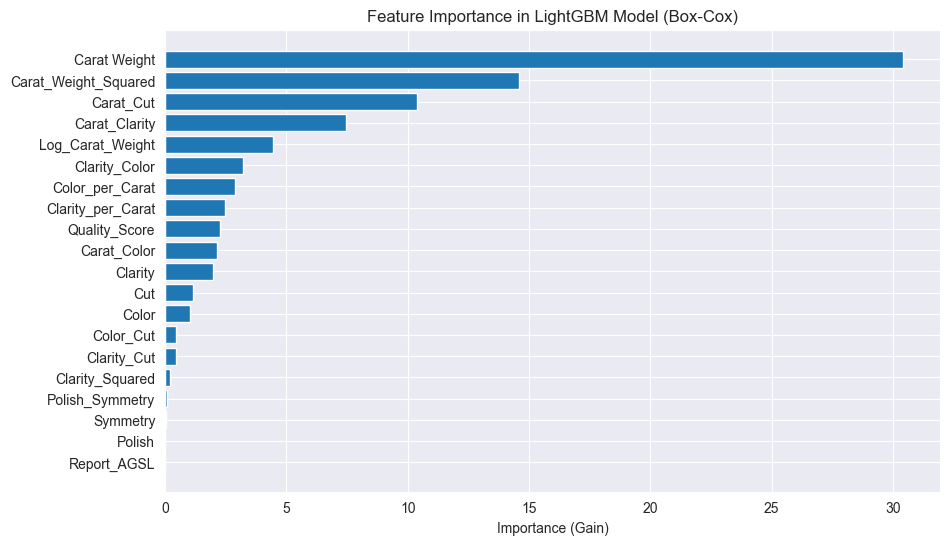

Test RMSE (Box-Cox): 1255.59
Test MAE (Box-Cox): 649.03
Test R² (Box-Cox): 0.9858


In [36]:
# Feature Engineering
df['Carat_Clarity'] = df['Carat Weight'] * df['Clarity']
df['Carat_Color'] = df['Carat Weight'] * df['Color']
df['Clarity_Color'] = df['Clarity'] * df['Color']
df['Carat_Cut'] = df['Carat Weight'] * df['Cut']
df['Polish_Symmetry'] = df['Polish'] * df['Symmetry']
df['Carat_Weight_Squared'] = df['Carat Weight'] ** 2
df['Clarity_Squared'] = df['Clarity'] ** 2
df['Clarity_per_Carat'] = df['Clarity'] / df['Carat Weight'].replace(0, np.nan)
df['Color_per_Carat'] = df['Color'] / df['Carat Weight'].replace(0, np.nan)
df['Clarity_Cut'] = df['Clarity'] * df['Cut']
df['Color_Cut'] = df['Color'] * df['Cut']
df['Log_Carat_Weight'] = np.log1p(df['Carat Weight'])
df['Quality_Score'] = df['Clarity'] + df['Color'] + df['Cut']

# Handle any NaN values from division
df = df.fillna(0)

# Define features and target
X = df.drop(columns=['Price', 'BoxCox_Price'])
y = df['BoxCox_Price']  # Use the Box-Cox transformed target

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Run Optuna study with tqdm progress bar
study2 = optuna.create_study(direction='minimize')
n_trials = 200
with tqdm(total=n_trials, desc="Optuna Trials") as pbar:
    def callback(study, trial):
        pbar.update(1)
    study2.optimize(objective, n_trials=n_trials, callbacks=[callback])

print(f"Best Optuna trial value (cross-validation RMSE, Box-Cox): {study2.best_value}")

# Train final model with best parameters
best_params2 = study2.best_params
best_params2.update({
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'verbosity': -1,
    'num_threads': 6  # Set to the number of physical cores (adjust based on your CPU)
})

train_data = lgb.Dataset(X_train, label=y_train)
final_model2 = lgb.train(best_params2, train_data, num_boost_round=1000)

# Extract feature importance (gain-based)
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': final_model2.feature_importance(importance_type='gain')
})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

print("\nFeature Importance (Gain-based) after Hyperparameter Tuning (Box-Cox):")
print(feature_importance)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance (Gain)')
plt.title('Feature Importance in LightGBM Model (Box-Cox)')
plt.gca().invert_yaxis()
plt.show()

# Evaluate on test set
y_pred_test_boxcox = final_model2.predict(X_test)
y_pred_test = inv_boxcox(y_pred_test_boxcox, lambda_param)
y_test_original = inv_boxcox(y_test, lambda_param)
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_test))
mae = mean_absolute_error(y_test_original, y_pred_test)
r2 = r2_score(y_test_original, y_pred_test)

print(f"Test RMSE (Box-Cox): {rmse:.2f}")
print(f"Test MAE (Box-Cox): {mae:.2f}")
print(f"Test R² (Box-Cox): {r2:.4f}")

In [37]:
# Define the models directory relative to the project root (from notebooks/)
models_dir = Path("..") / "models"

# Create the models directory if it doesn't exist
models_dir.mkdir(exist_ok=True)

# Save the model to a pickle file
model_path = models_dir / "diamond_price_model_boxcox.pkl"
with model_path.open("wb") as f:
    pickle.dump(final_model2, f)

print(f"Model saved to '{model_path}'")

# Save the lambda parameter for back-transformation in the Flask app
lambda_path = models_dir / "boxcox_lambda.pkl"
with lambda_path.open("wb") as f:
    pickle.dump(lambda_param, f)

print(f"Box-Cox lambda parameter saved to '{lambda_path}'")

Model saved to '..\models\diamond_price_model_boxcox.pkl'
Box-Cox lambda parameter saved to '..\models\boxcox_lambda.pkl'


In [38]:
# Back-transform predictions to original scale
df= df_check.copy()  # Create a copy for predictions
df['Carat_Clarity'] = df['Carat Weight'] * df['Clarity']
df['Carat_Color'] = df['Carat Weight'] * df['Color']
df['Clarity_Color'] = df['Clarity'] * df['Color']
df['Carat_Cut'] = df['Carat Weight'] * df['Cut']
df['Polish_Symmetry'] = df['Polish'] * df['Symmetry']
df['Carat_Weight_Squared'] = df['Carat Weight'] ** 2
df['Clarity_Squared'] = df['Clarity'] ** 2
df['Clarity_per_Carat'] = df['Clarity'] / df['Carat Weight'].replace(0, np.nan)
df['Color_per_Carat'] = df['Color'] / df['Carat Weight'].replace(0, np.nan)
df['Clarity_Cut'] = df['Clarity'] * df['Cut']
df['Color_Cut'] = df['Color'] * df['Cut']
df['Log_Carat_Weight'] = np.log1p(df['Carat Weight'])
df['Quality_Score'] = df['Clarity'] + df['Color'] + df['Cut']


with open('../models/diamond_price_model_boxcox.pkl', 'rb') as f:
    model = pickle.load(f)
preds_boxcox = model.predict(df.drop(columns=['Price']))
df['Predicted_Price'] = inv_boxcox(preds_boxcox, lambda_param)
df['Price_Difference'] = df['Predicted_Price'] - df['Price']

# Define high-quality criteria
high_quality = df[
    (df['Cut'] >= 4) &
    (df['Color'] >= 6) &
    (df['Clarity'] >= 5)
]

# Reverse the encoding for saving the dataset
df['Cut'] = df['Cut'].map({v: k for k, v in cut_mapping.items()})
df['Color'] = df['Color'].map({v: k for k, v in color_mapping.items()})
df['Clarity'] = df['Clarity'].map({v: k for k, v in clarity_mapping.items()})
df['Polish'] = df['Polish'].map({v: k for k, v in polish_symmetry_mapping.items()})
df['Symmetry'] = df['Symmetry'].map({v: k for k, v in polish_symmetry_mapping.items()})
df['Report'] = df['Report_AGSL'].map({1 : 'AGSL', 0 : 'GIA'})
df.drop(columns=['Report_AGSL'], inplace=True)

# Identify undervalued high-quality diamonds
undervalued = high_quality[df['Price_Difference'] > 0].sort_values('Price_Difference', ascending=False)

# Display top 5
print("Top 20 Undervalued High-Quality Diamonds:")
print(undervalued[['Carat Weight', 'Cut', 'Color', 'Clarity', 'Report_AGSL', 'Price', 'Price_Difference']].head(20))

# Save the updated dataset with Predicted_Price and Price_Difference
df[['Carat Weight', 'Cut', 'Color', 'Clarity', 'Polish', 'Symmetry', 'Report', 'Price',
   'Predicted_Price', 'Price_Difference']].to_csv('diamonds_with_predictions.csv', index=False)
print("Dataset with predictions saved to 'diamonds_with_predictions.csv'")

Top 20 Undervalued High-Quality Diamonds:
      Carat Weight  Cut  Color  Clarity  Report_AGSL    Price  \
4191          2.11    4      7        6        False  43770.0   
785           2.02    4      7        8        False  59282.0   
3090          2.11    4      7        7        False  49740.0   
3479          1.52    4      7        8        False  24715.0   
1013          2.25    4      6        5        False  31724.0   
727           1.72    4      7        8        False  38080.0   
2993          2.70    4      7        5        False  50350.0   
1924          2.51    4      7        5        False  46395.0   
5633          2.36    4      7        8        False  72195.0   
4572          2.00    4      7        7        False  47879.0   
4950          2.12    4      6        5        False  31248.0   
5999          2.19    4      6        5        False  30507.0   
3134          2.00    4      6        6        False  31924.0   
5219          2.03    4      7        6        F

C:\Users\Admin\AppData\Local\Temp\ipykernel_12488\475507142.py:41: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  undervalued = high_quality[df['Price_Difference'] > 0].sort_values('Price_Difference', ascending=False)
